In [109]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn import metrics
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from concept_erasure import LeaceEraser

def purity(model_labels, gold_labels): 
    """
    Calculates the Purity metric as described in https://aclanthology.org/P16-1110/
    "ALTO: Active Learning with Topic Overviews for Speeding Label Induction and Document Labeling"
    
    For sanity check - The purity of any two user labels should be 1
    """
    assert len(model_labels) == len(gold_labels)

    # somewhat faster than a pure-python implementation
    purity_sum = (
        pd.DataFrame({"pred": model_labels, "true": gold_labels})
          .groupby(["pred", "true"], as_index=False)
          .size()
          .groupby("pred")["size"]
          .max()
          .sum()
    )
    return purity_sum / len(model_labels)

majortopic_mappings = {
    '1.0': 'Macroeconomics',
    '2.0': 'Civil Rights',
    '3.0': 'Health',
    '4.0': 'Agriculture', 
    '5.0': 'Labor', 
    '6.0': 'Education',
    '7.0': 'Environment',
    '8.0': 'Energy',
    '9.0': 'Immigration',
    '10.0': 'Transportation',
    '12.0': 'Law and Crime',
    '13.0': 'Social Welfare',
    '14.0': 'Housing',
    '15.0': 'Domestic Commerce',
    '16.0': 'Defense',
    '17.0': 'Technology',
    '18.0': 'Foreign Trade',
    '19.0': 'International Affairs',
    '20.0': 'Government Operations',
    '21.0': 'Public Lands',
    '23.0': 'Culture',
}

sample_size = 32

### Newspaper

In [110]:
# Load and prepare the dataset
newspaper = pd.read_csv('CAP_NewspaperClips1979_2015.csv')
newspaper['majortopic'] = newspaper['majortopic'].astype(str)
newspaper['year'] = newspaper['year'].astype(str)
newspaper = newspaper.dropna(subset=['year', 'majortopic', 'abstract', 'headline'])

newspaper['summary'] = newspaper['headline'] + '\n' + newspaper['abstract']

# Ensure the 'majortopic' column is of string type for mapping
newspaper['majortopic'] = newspaper['majortopic'].astype(str)

# Drop rows where 'majortopic' is '0.0' (as string) or NaN
newspaper = newspaper[~((newspaper['majortopic'] == '0.0') | (newspaper['majortopic'] == 'nan'))]

# Create new 'topic' column using the mapping
newspaper['topic'] = newspaper['majortopic'].map(majortopic_mappings)

# Group by 'topic' and sample 100 rows per topic if at least 100 rows are available
newspaper_sample = (
    newspaper.groupby('topic')
         .filter(lambda x: len(x) >= sample_size)  # Keep groups with at least 100 rows
         .groupby('topic')
         .sample(n=sample_size, random_state=42)   # Randomly sample 100 rows per group
         .reset_index(drop=True)
)[['summary', 'topic']] 

newspaper_sample = newspaper_sample.rename(columns={'summary': 'text'})

### Bills

In [111]:
def read_jsonl(file_path, encoding='utf-8'):
    """
    Reads a .jsonl (JSON Lines) file and returns a list of dictionaries.
    
    Args:
        file_path (str): Path to the .jsonl file.
        
    Returns:
        List[dict]: A list of parsed JSON objects.
    """
    data = []
    with open(file_path, 'r', encoding=encoding) as f:
        for line in f:
            if line.strip():  # Skip empty lines
                data.append(json.loads(line))

    return pd.DataFrame(data)

bills_train = read_jsonl('train.metadata.jsonl') 
bills_test = read_jsonl('test.metadata.jsonl')

bills = pd.concat([bills_train, bills_test])

bills['subtopic'] = bills['topic'] + ' - ' + bills['subtopic']

# Group by 'topic' and sample 100 rows per topic if at least 100 rows are available
bills_sample = (
    bills.groupby('topic')
         .filter(lambda x: len(x) >= sample_size)  # Keep groups with at least n rows
         .groupby('topic')
         .sample(n=sample_size, random_state=42)   # Randomly sample n rows per group
         .reset_index(drop=True)
)[['summary', 'topic']]

bills_sample = bills_sample.rename(columns={'summary': 'text'})

### Executive Orders

In [112]:
eos = pd.read_csv('merged_eo_full_with_text.csv')
eos_cap = pd.read_csv('US-Executive-executive_orders_21.3.csv')

eos = eos.dropna(subset=['eo_number', 'extracted_text'])

# Function to extract main Executive Order text
def extract_main_text(row):
    number = str(row['eo_number'])  # Ensure it's a string
    text = str(row['extracted_text'])  # Ensure it's a string
    
    # Regex pattern: case-insensitive and dot matches newlines
    pattern = rf"(?is)(executive order {re.escape(number)} of .*?)(the white house,.*?$)"
    
    match = re.search(pattern, text)
    if match:
        return match.group(1) + match.group(2)
    return None

# Example: Apply the function to the DataFrame
eos['text'] = eos.apply(extract_main_text, axis=1)

eos = eos.dropna(subset=['text'])

eos['eo_number'] = eos['eo_number'].astype(int).astype(str)
eos_cap['eo_number'] = eos_cap['eo_number'].astype(int).astype(str)

eos_cap['majortopic'] = eos_cap['majortopic'].astype(float).astype(str)
eos_cap['topic'] = eos_cap['majortopic'].map(majortopic_mappings)
eo_mappings = eos_cap.drop_duplicates(subset='eo_number').set_index('eo_number')['topic'].to_dict()
eos['topic'] = eos['eo_number'].map(eo_mappings)

# Group by 'topic' and sample 100 rows per topic if at least 100 rows are available
eos_sample = (
    eos.groupby('topic')
         .filter(lambda x: len(x) >= sample_size)  # Keep groups with at least n rows
         .groupby('topic')
         .sample(n=sample_size, random_state=42)   # Randomly sample n rows per group
         .reset_index(drop=True)
)[['text', 'topic']]

### Erasure

In [117]:
newspaper_sample['source'] = 'newspaper'
bills_sample['source'] = 'bills'
eos_sample['source'] = 'eos'

def plot_erasure_results(samples, model='sentence-transformers/all-MiniLM-L6-v2'):

    n_sources = samples['source'].nunique()
    
    # Step 1: Count the number of rows per topic
    topic_counts = samples['topic'].value_counts()

    # Step 2: Filter topics that have exactly `2 * sample_size` rows
    topics_with_sample_size = topic_counts[topic_counts == n_sources * sample_size].index

    # Step 3: Keep only rows where the topic is in the filtered list
    samples = samples[samples['topic'].isin(topics_with_sample_size)]

    # Load MiniLM model
    model = SentenceTransformer(model)

    # Compute embeddings for the summary column
    embeddings = model.encode(samples['text'].tolist(), show_progress_bar=True)

    # Compute embeddings
    embeddings = torch.from_numpy(embeddings)

    # Convert string labels to numeric
    numeric_labels = torch.tensor([0 if label == 'newspaper' else 1 for label in samples['source'].to_list()])

    # Run LEACE erasure
    eraser = LeaceEraser.fit(embeddings, numeric_labels)
    embeddings_erased = eraser(embeddings)

    purity_before, purity_after = [], []
    adjusted_rand_score_before, adjusted_rand_score_after = [], []
    adjusted_mutual_info_score_before, adjusted_mutual_info_score_after = [], []
    n_clusters = list(range(2, 33))
    gold_labels = samples['topic'].to_list()

    for n in range(2, 33):

        # Run KMeans clustering
        kmeans = KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Add cluster labels to the dataframe
        samples['cluster_label_before'] = cluster_labels

        model_labels = samples['cluster_label_before'].to_list()
        
        p = purity(model_labels, gold_labels)
        r = metrics.adjusted_rand_score(gold_labels, model_labels)
        m = metrics.adjusted_mutual_info_score(gold_labels, model_labels)  
        purity_before.append(p)
        adjusted_rand_score_before.append(r)
        adjusted_mutual_info_score_before.append(m)

        # Run KMeans clustering
        kmeans = KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings_erased)

        # Add cluster labels to the dataframe
        samples['cluster_label_after'] = cluster_labels

        model_labels = samples['cluster_label_after'].to_list()

        p = purity(model_labels, gold_labels)
        r = metrics.adjusted_rand_score(gold_labels, model_labels)
        m = metrics.adjusted_mutual_info_score(gold_labels, model_labels)  
        purity_after.append(p)
        adjusted_rand_score_after.append(r)
        adjusted_mutual_info_score_after.append(m)

    # Plotting Purity Score
    plt.figure(figsize=(8, 5))
    plt.plot(n_clusters, purity_before, label='Before', color='midnightblue', marker='.', markersize=8)
    plt.plot(n_clusters, purity_after, label='After', color='darkorange', marker='.', markersize=8)

    plt.title('Purity Score Before vs After Erasure under Different Cluster Counts')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Purity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting Adjusted Mutual Info Score
    plt.figure(figsize=(8, 5))
    plt.plot(n_clusters, adjusted_mutual_info_score_before, label='Before', color='midnightblue', marker='.', markersize=8)
    plt.plot(n_clusters, adjusted_mutual_info_score_after, label='After', color='darkorange', marker='.', markersize=8)

    plt.title('Adjusted Mutual Info Score Before vs After Erasure under Different Cluster Counts')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting Adjusted Rand Score
    plt.figure(figsize=(8, 5))
    plt.plot(n_clusters, adjusted_rand_score_before, label='Before', color='midnightblue', marker='.', markersize=8)
    plt.plot(n_clusters, adjusted_rand_score_after, label='After', color='darkorange', marker='.', markersize=8)

    plt.title('Adjusted Rand Score Before vs After Erasure under Different Cluster Counts')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Batches: 100%|██████████| 38/38 [00:02<00:00, 15.69it/s]
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['cluster_label_before'] = cluster_labels
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['cluster_label_after'] = cluster_labels
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:47: SettingWithCopyWarni

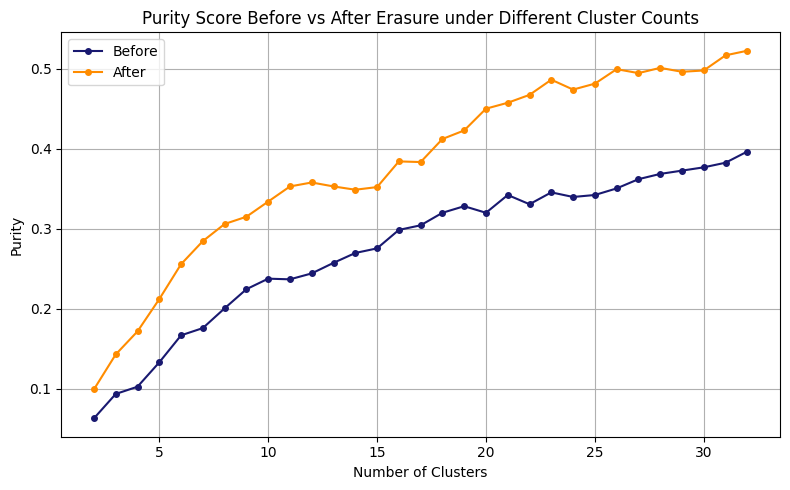

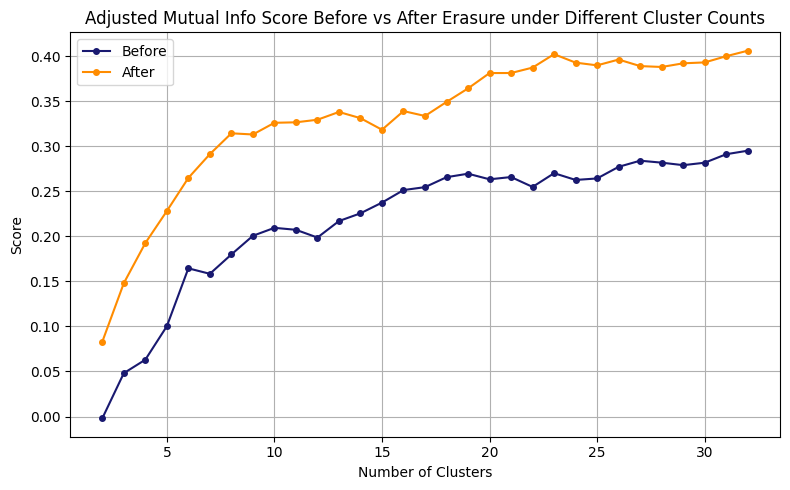

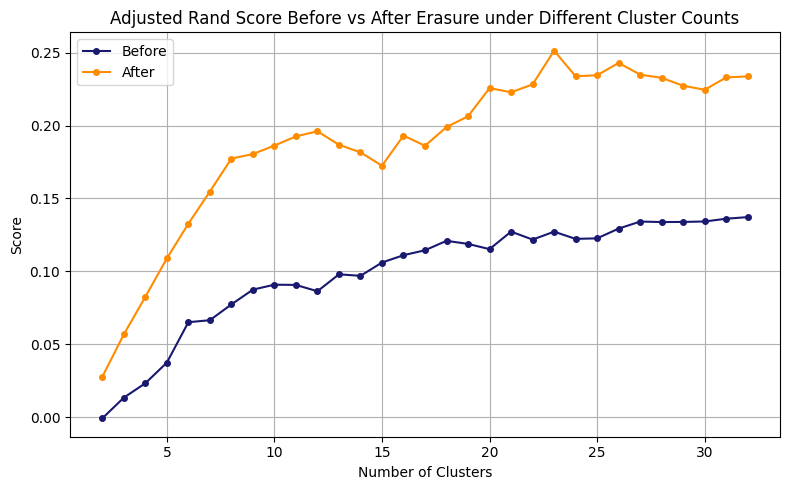

In [118]:
samples = pd.concat([bills_sample, newspaper_sample])
plot_erasure_results(samples)

Batches: 100%|██████████| 20/20 [00:01<00:00, 11.16it/s]
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['cluster_label_before'] = cluster_labels
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['cluster_label_after'] = cluster_labels
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:47: SettingWithCopyWarni

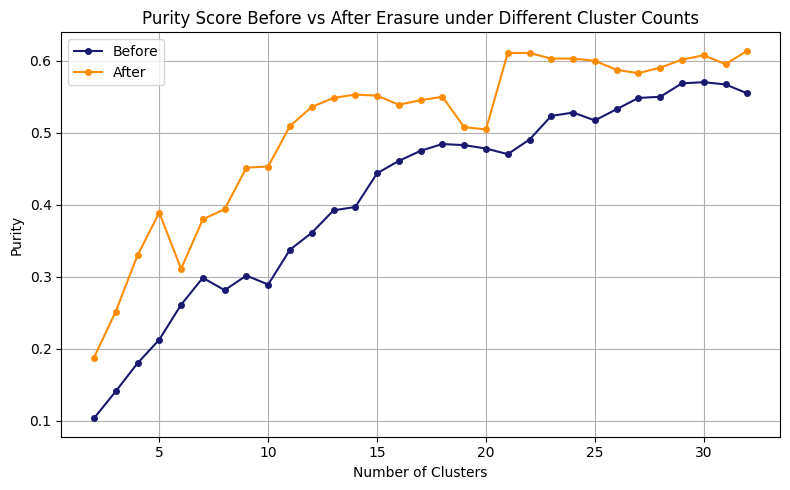

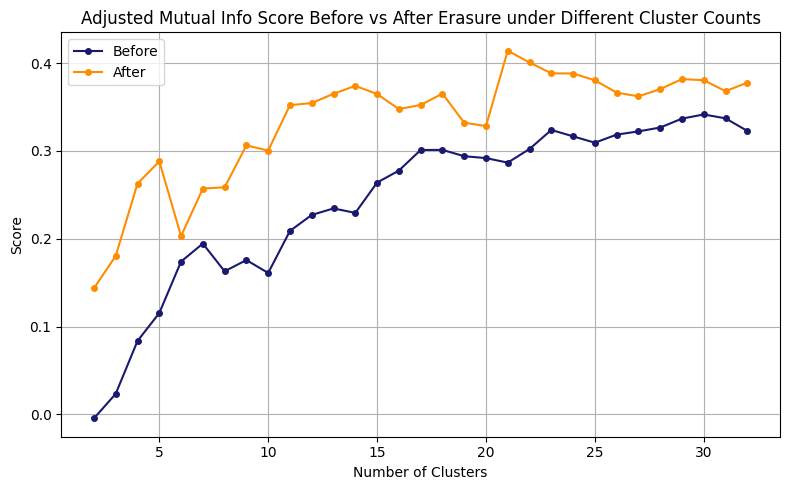

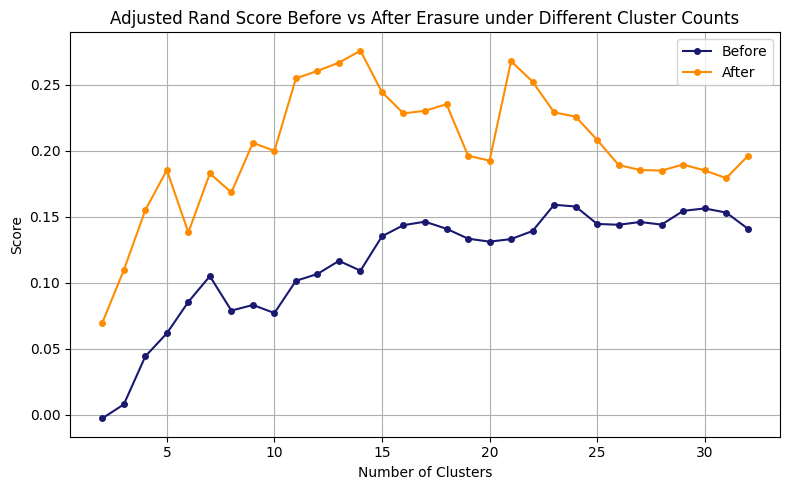

In [119]:
samples = pd.concat([eos_sample, newspaper_sample])
plot_erasure_results(samples)

Batches: 100%|██████████| 30/30 [00:02<00:00, 11.13it/s]
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['cluster_label_before'] = cluster_labels
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['cluster_label_after'] = cluster_labels
/var/folders/_0/bnxdwf8j50ndf6f7_81l30x40000gq/T/ipykernel_1973/1725980878.py:47: SettingWithCopyWarni

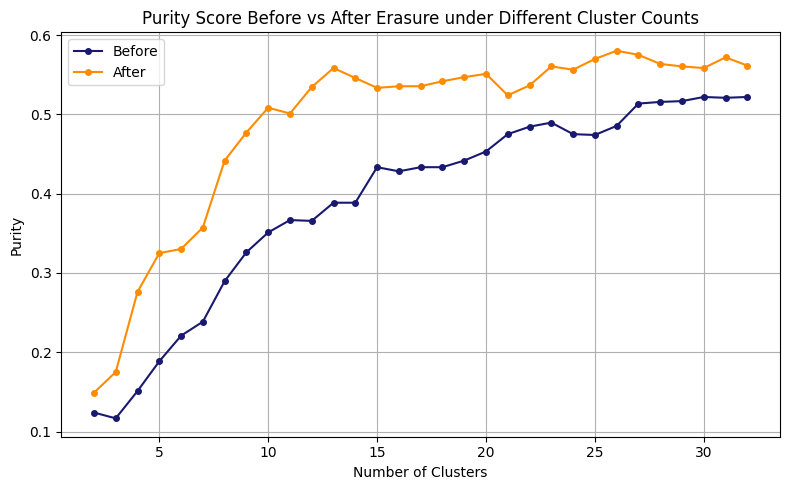

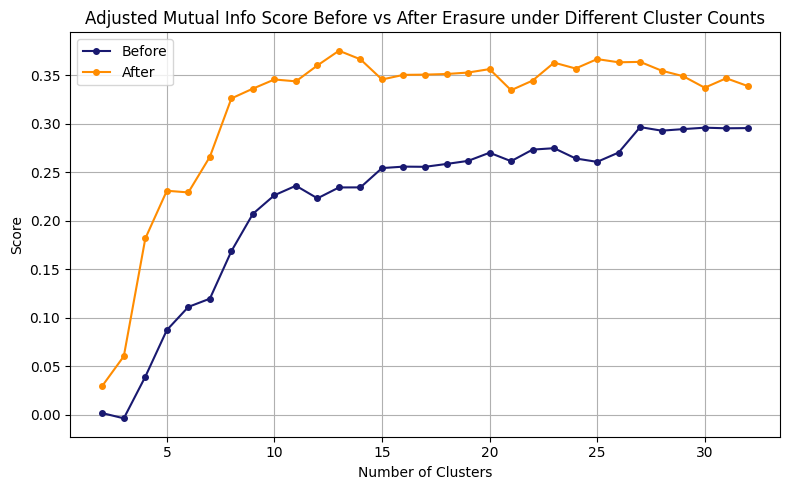

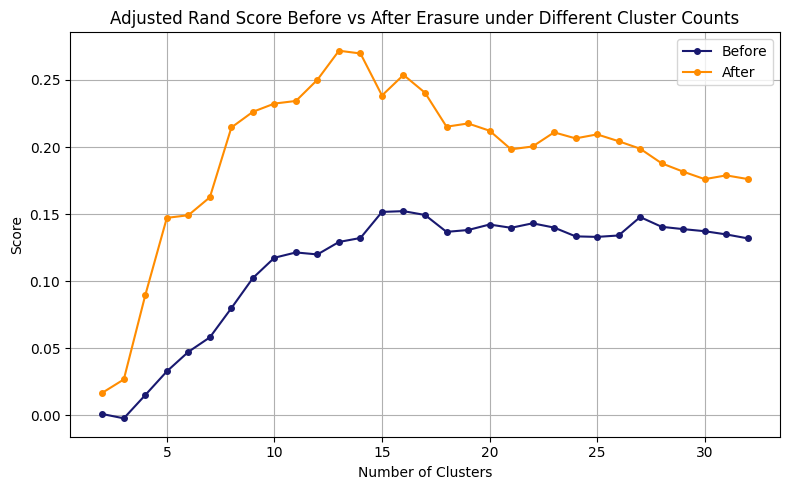

In [120]:
samples = pd.concat([eos_sample, bills_sample, newspaper_sample])
plot_erasure_results(samples)